In [1]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from SALib.analyze import delta, pawn, rbd_fast, hdmr
from SALib.sample import latin
import MoNeT_MGDrivE as monet
from collections import OrderedDict
import compress_pickle as pkl
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap, ColorConverter
from tensorflow import keras
from os import path
from keras.models import load_model
import compress_pickle as pkl
import constants as cst
from itertools import product
import shap
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from timeit import default_timer as timer
from sklearn.inspection import PartialDependenceDisplay

2023-09-26 07:39:27.813430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## MoNeT_DA/PAN/PGS/PGS_gene_FMS5.py

In [2]:
###############################################################################
genotypes = (
    "AABBCCDD", "aABBCCDD", "AAbBCCDD", "aAbBCCDD", "AABBcCDD", "aABBcCDD", 
    "AAbBcCDD", "aAbBcCDD", "AABBCCdD", "aABBCCdD", "AAbBCCdD", "aAbBCCdD", 
    "AABBcCdD", "aABBcCdD", "AAbBcCdD", "aAbBcCdD", "aaBBCCDD", "aabBCCDD", 
    "aaBBcCDD", "aabBcCDD", "aaBBCCdD", "aabBCCdD", "aaBBcCdD", "aabBcCdD", 
    "AAbbCCDD", "aAbbCCDD", "AAbbcCDD", "aAbbcCDD", "AAbbCCdD", "aAbbCCdD", 
    "AAbbcCdD", "aAbbcCdD", "aabbCCDD", "aabbcCDD", "aabbCCdD", "aabbcCdD",
    "AABBccDD", "aABBccDD", "AAbBccDD", "aAbBccDD", "AABBccdD", "aABBccdD", 
    "AAbBccdD", "aAbBccdD", "aaBBccDD", "aabBccDD", "aaBBccdD", "aabBccdD", 
    "AAbbccDD", "aAbbccDD", "AAbbccdD", "aAbbccdD", "aabbccDD", "aabbccdD", 
    "AABBCCdd", "aABBCCdd", "AAbBCCdd", "aAbBCCdd", "AABBcCdd", "aABBcCdd", 
    "AAbBcCdd", "aAbBcCdd", "aaBBCCdd", "aabBCCdd", "aaBBcCdd", "aabBcCdd", 
    "AAbbCCdd", "aAbbCCdd", "AAbbcCdd", "aAbbcCdd", "aabbCCdd", "aabbcCdd", 
    "AABBccdd", "aABBccdd", "AAbBccdd", "aAbBccdd", "aaBBccdd", "aabBccdd", 
    "AAbbccdd", "aAbbccdd", "aabbccdd"
)
(locA, locB, locC, locD) = ((0, 1), (2, 3), (4, 5), (6, 7))

###############################################################################
# Health genotype counts (gRNA)
###############################################################################
HLT_DICT = OrderedDict((
    ('T*',   (('A', locA), ('B', locB), ('C', locC), ('D', locD))),
    ('O-',   (('a', locA), ('b', locB), ('c', locC), ('d', locD)))
))

PGS_HLT = monet.carrierFrequencies(HLT_DICT, genotypes)
PGS_HLT = [PGS_HLT[0], [PGS_HLT[1][0], PGS_HLT[1][-1], PGS_HLT[1][-1]]]

###############################################################################
# Drive Selector
###############################################################################
def driveParameters(TYPE, popSize):
    if TYPE == 'ECO':
        aggD = monet.generateAggregationDictionary(*PGS_ECO)
        yRange = popSize*4
    elif TYPE == 'HLT':
        aggD = monet.generateAggregationDictionary(*PGS_HLT)
        yRange = popSize
    elif TYPE == 'TRS':
        aggD = monet.generateAggregationDictionary(*PGS_TRS)
        yRange = popSize/2
    elif TYPE == 'WLD':
        aggD = monet.generateAggregationDictionary(*PGS_WLD)
        yRange = popSize/2
    return (aggD, yRange, 'pgSIT')

## MoNeT_DA/PAN/PGS/PGS_gene.py

In [3]:
import MoNeT_MGDrivE as monet

###############################################################################
# Drive
###############################################################################
def driveSelector(DRIVE, TYPE, popSize=(100*12000)):
    ###########################################################################
    if (DRIVE == 'FMS3'):
        (aggD, yRange, folder) = FMS3.driveParameters(TYPE, popSize)
    elif (DRIVE == 'FMS4'):
        (aggD, yRange, folder) = FMS4.driveParameters(TYPE, popSize)
    elif (DRIVE == 'FMS5'):
        (aggD, yRange, folder) = FMS5.driveParameters(TYPE, popSize)
    elif (DRIVE == 'PGS'):
        (aggD, yRange, folder) = driveParameters(TYPE, popSize)
    elif (DRIVE == 'IIT'):
        (aggD, yRange, folder) = IIT.driveParameters(TYPE, popSize)
    elif (DRIVE == 'RDL'):
        (aggD, yRange, folder) = RDL.driveParameters(TYPE, popSize)
    elif (DRIVE == 'RDF'):
        (aggD, yRange, folder) = RDF.driveParameters(TYPE, popSize)
    else:
        print("Error in gene drive ID")
    ###########################################################################
    if TYPE == 'ECO':
        colors = [
            '#2614ed55', '#FF006E55', '#45d40c55', '#8338EC55', '#1888e355', 
            '#BC109755', '#FFE93E55', '#3b479d55', '#540d6e55', '#7bdff255'
        ]
    elif TYPE == 'HLT':
        if DRIVE == 'FMS3':
            colors = ['#1888e300', '#2614ed00', '#f2008935']
        elif DRIVE == 'FMS4':
            colors = ['#1888e300', '#2614ed00', '#3b479d35']
        elif DRIVE == 'FMS5':
            colors = ['#1888e300', '#2614ed00', '#45d40c35']
        elif DRIVE == 'PGS':
            colors = ['#1888e335', '#2614ed35', '#8338EC35']
        elif DRIVE == 'IIT':
            colors = ['#f2008900', '#c879ff00', '#540d6e35']
        elif DRIVE == 'RDL':
            colors = ['#f2008900', '#c879ff00', '#bbdefb35']
        elif DRIVE == 'RDF':
            colors = ['#f2008900', '#c879ff00', '#1888e335']
        else:
            colors = ['#f2008955', '#c879ff55', '#c879ff35']
    elif TYPE == 'TRS':
        colors = monet.COLTN
    elif TYPE == 'WLD':
        colors = monet.COLWN
    elif TYPE == 'HUM':
        colors = ['#274c7700', '#c879ff99', '#dee2ff55']
    elif TYPE == 'INC':
        colors = ['#8CD9FF00', '#bbdefb55', '#dee2ff00']
    ###########################################################################
    geneDict = {
        'gDict': aggD, 'yRange': yRange, 'colors': colors, 'folder': folder
    }
    return geneDict

def maleFemaleSelector(AOI):
    if (AOI == 'HLT') or (AOI == 'INC'):
        MF = (False, True)
    elif (AOI == 'HUM'):
        MF = (False, True)
    else:
        MF = (True, True)
    return MF

def colorSelector(AOI):
    if AOI == 'ECO':
        colors = monet.COLEO
    elif AOI == 'HLT':
        colors = monet.COLHO
    elif AOI == 'TRS':
        colors = monet.COLTO
    elif AOI == 'WLD':
        colors = monet.COLWO
    return colors

## MoNeT_DA/PAN/PGS/PGS_aux.py

In [4]:
if monet.isNotebook():
    (USR, DRV, QNT, AOI, THS, MOI) = ('dsk', 'PGS', '50', 'HLT', '0.1', 'CPT')
else:
    (USR, DRV, QNT, AOI, THS, MOI) = sys.argv[1:]
QNT = (None if QNT == 'None' else QNT)
MOD_SEL = 'mlp'

In [5]:
XP_ID = 'PGS'
###############################################################################
# System Constants
###############################################################################
(OVW, JOB_DSK, JOB_SRV) = (True, 4, 32)
(SUM, AGG, SPA, REP, SRP) = (True, False, False, False, True)
###############################################################################
# Releases and Populations
###############################################################################
(REL_START, RELEASES) = (50, [365+(7*i) for i in range(10)])
(POP_SIZE, HUM_SIZE, INC_SIZE, XRAN, FZ) = (
    5e3, 1e3, 1000*1.25,
    (REL_START, 5*int(365)), 
    False
)
(STABLE_T, MLR, SAMP_RATE) = (0, False, 1)
MAX_REPS = 80
###############################################################################
# Sensitivity Analysis
###############################################################################

SA_SAMPLES = 2**16
SA_RANGES = (
    ('ren', (1, 52)), 
    ('rer', (1, 50)), 
    ('rei', (1, 15)),
    ('pct', (.5, 1)), 
    ('pmd', (.5, 1)), 
    ('mfr', (0, .5)), 
    ('mtf', (.5, 1)), 
    ('fvb', (0, .5))
)

In [6]:
def landSelector():
    PAN = ([0], )
    return PAN

###############################################################################
# Paths
###############################################################################
def selectPath(USR, DRV=None):
    if USR == 'srv':
        PATH_ROOT = '/RAID5/marshallShare/pgSIT2/{}/'.format(DRV)
    elif USR == 'dsk':
        PATH_ROOT = '/Users/xingliyu/Desktop/Marshall_lab_summer23/WorkSims/pgSIT2/{}/'.format(DRV)
    (PATH_IMG, PATH_DATA) = (
        '{}img/'.format(PATH_ROOT), 
        '{}'.format(PATH_ROOT)
    )
    PATH_PRE = PATH_DATA + 'PREPROCESS/'
    PATH_OUT = PATH_DATA + 'POSTPROCESS/'
    PATH_MTR = PATH_DATA + 'SUMMARY/'
    fldrList = [PATH_ROOT, PATH_IMG, PATH_DATA, PATH_PRE, PATH_OUT, PATH_MTR]
    [monet.makeFolder(i) for i in fldrList]
    return (PATH_ROOT, PATH_IMG, PATH_DATA, PATH_PRE, PATH_OUT, PATH_MTR)

In [7]:
(XP_PTRN, NO_REL_PAT) = ('E_{}_{}_{}_{}_{}_{}_{}_{}-{}_{}_{}.{}', '00')
(DATA_NAMES, DATA_PRE, DATA_PST) = (
    ('TTI', 'TTO', 'WOP', 'RAP', 'MNX', 'CPT', 'CPT'),
    ('ECO', 'HLT', 'TRS', 'WLD'), ('HLT', 'TRS', 'WLD')
)
# Data Analysis ---------------------------------------------------------------
(DATA_HEAD, DATA_SCA, DATA_PAD, DATA_TYPE) = (
    (
        ('i_ren', 1), ('i_res', 2), ('i_rei', 3),
        ('i_pct', 4), ('i_pmd', 5), 
        ('i_mfr', 6), ('i_mtf', 7), ('i_fvb', 8),
        ('i_grp', 10)
    ),
    {
        'i_ren': 1e0,  'i_res': 1e8, 'i_rei': 1e0,
        'i_pct': 1e10, 'i_pmd': 1e10, 
        'i_mfr': 1e10, 'i_mtf': 1e10, 'i_fvb': 1e10,
        'i_grp': 1e0
    },
    {
        'i_ren': 4,  'i_res': 14, 'i_rei': 4,
        'i_pct': 12, 'i_pmd': 12, 
        'i_mfr': 12, 'i_mtf': 12, 'i_fvb': 12,
        'i_grp': 2
    },
    {
        'i_ren': np.int8,   'i_res': np.double, 'i_rei': np.int8,
        'i_pct': np.double, 'i_pmd': np.double, 
        'i_mfr': np.double, 'i_mtf': np.double, 'i_fvb': np.double,
        'i_grp': np.int8
    }
)

In [8]:
###############################################################################
# Dependent Variables for Heatmaps
###############################################################################
def colorPaletteFromHexList(clist):
    c = ColorConverter().to_rgba
    clrs = [c(i) for i in clist]
    rvb = LinearSegmentedColormap.from_list("", clrs)
    return rvb


def selectDepVars(MOI):
    # Select ranges and dependent variable-------------------------------------
    if (MOI == 'WOP') or (MOI == 'TTO'):
        scalers = [1, 1, XRAN]
        (HD_DEP, IND_RAN) = ('0.1', 7)
    elif (MOI == 'TTI'):
        scalers = [1, 1, XRAN]
        (HD_DEP, IND_RAN) = ('0.1', 7)
    elif (MOI == 'RAP'):
        scalers = [1, 100, 90]
        (HD_DEP, IND_RAN) = ('486', 7)
    elif (MOI == 'MNX'):
        scalers = [1, 100, 1]
        (HD_DEP, IND_RAN) = ('min', 7)
    elif (MOI == 'POE'):
        scalers = [1, 100, 1]
        (HD_DEP, IND_RAN) = ('POE', 1) 
    elif (MOI == 'CPT'):
        scalers = [1, 100, 1]
        (HD_DEP, IND_RAN) = ('CPT', 1) 
    elif (MOI == 'DER'):
        scalers = [1, 100, 5]
        (HD_DEP, IND_RAN) = ('DER', 5) 
    elif (MOI == 'MNF'):
        scalers = [1, 1, 1]
        (HD_DEP, IND_RAN) = ('MNF', 1) 
    # Color Mapping -----------------------------------------------------------
    if MOI == 'WOP':
        cmap = colorPaletteFromHexList(['#ffffff00', '#03045eAA'])
    elif MOI == 'CPT':
        cmap = colorPaletteFromHexList(['#ffffff00', '#3a86ffAA'])
    elif MOI == 'POE':
        cmap = colorPaletteFromHexList(['#ffffff00', '#8338ECAA'])
    else:
        cmap = colorPaletteFromHexList(['#ffffff00', '#3b479dAA'])
    return (scalers, HD_DEP, IND_RAN, cmap)

In [9]:
def unison_shuffled_copies(a, b, size=1000):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p][:size], b[p][:size]

In [10]:
def selectColor(MOI):
    if MOI=='CPT':
        clr = '#3a86ff'
    elif MOI=='POE':
        clr = '#8338EC'
    else:
        clr = '#03045e'
    return clr

In [11]:
def getSASortedDF(df, column, sortingLabels, normalized=True):
    srtNames = [i.replace('i_', '') for i in sortingLabels]
    srtNames = list(map(lambda x: x.replace('rer', 'res'), srtNames))
    try:
        # SA dataframes -------------------------------------------------------
        names = list(df['names'])
        names = list(map(lambda x: x.replace('rer', 'res'), names))
    except:
        # ML dataframes -------------------------------------------------------
        names = list(df['Feature'])
        names = [i.replace('i_', '') for i in names]
    sortIx = [names.index(lbl) for lbl in srtNames]
    # Calculate return --------------------------------------------------------
    if normalized:
        norms = df[column]/np.nansum(df[column])
    else:
        norms = df[column]
    # Return sorted -----------------------------------------------------------
    srtSA = [norms[ix] for ix in sortIx]
    return srtSA

## MoNeT_DA/PAN/PGS/PGS_mlrHeatmap.py

In [12]:
# Setup number of threads -----------------------------------------------------
JOB = JOB_DSK
if USR == 'srv':
    JOB = JOB_SRV
CHUNKS = JOB
# Params Scaling --------------------------------------------------------------
(xSca, ySca) = ('linear', 'linear')
TICKS_HIDE = True
MAX_TIME = 365*2
CLABEL_FONTSIZE = 0
thsStr = str(int(float(THS)*100))
###############################################################################
# Paths
###############################################################################
(drive, land) = (
    driveSelector(DRV, AOI, popSize=POP_SIZE),
    landSelector()
)
(gene, fldr) = (drive.get('gDict'), drive.get('folder'))
(PT_ROT, PT_IMG, PT_DTA, PT_PRE, PT_OUT, PT_MTR) = selectPath(USR, fldr)
PT_OUT = path.join(PT_ROT, 'ML')
PT_IMG = path.join(PT_OUT, 'img', 'heat')
[monet.makeFolder(i) for i in [PT_OUT, PT_IMG]]
PT_SUMS = path.join(PT_ROT, 'SUMMARY')
# Time and head ---------------------------------------------------------------
tS = datetime.now()
monet.printExperimentHead(
    PT_ROT, PT_OUT, tS, 
    '{} mlrHeatmap [{}:{}:{}]'.format(DRV, AOI, THS, MOI)
)

* [2023-09-26 07:39:36.255384] MoNeT PGS mlrHeatmap [HLT:0.1:CPT]
* I: /Users/xingliyu/Desktop/Marshall_lab_summer23/WorkSims/pgSIT2/pgSIT/
* O: /Users/xingliyu/Desktop/Marshall_lab_summer23/WorkSims/pgSIT2/pgSIT/ML


## MoNeT_DA/PAN/PGM/PGS_mlrTrainML.py

In [13]:
###############################################################################
# Load Model
###############################################################################
if QNT:
    fNameOut = '{}_{}Q_{}T_{}-{}-MLR'.format(
        AOI, int(QNT), int(float(THS)*100), MOI, MOD_SEL
    )
else:
    fNameOut = '{}_{}T_{}-{}-MLR'.format(AOI, int(float(THS)*100), MOI, MOD_SEL)
# Check for Keras model -------------------------------------------------------
if not (MOD_SEL == 'krs'):
    rf = pkl.load(path.join(PT_OUT, fNameOut+'.pkl'))
    print('yes')
else:
    rf = keras.models.load_model(path.join(PT_OUT, fNameOut))
    print('no')

yes


Trying to unpickle estimator MinMaxScaler from version 1.1.3 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPRegressor from version 1.1.3 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.1.3 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [14]:
path.join(PT_OUT, fNameOut+'.pkl')

'/Users/xingliyu/Desktop/Marshall_lab_summer23/WorkSims/pgSIT2/pgSIT/ML/HLT_50Q_10T_CPT-mlp-MLR.pkl'

In [15]:
###############################################################################
# Read Dataframe
###############################################################################
if QNT:
    fName = 'SCA_{}_{}Q_{}T.csv'.format(AOI, int(QNT), int(float(THS)*100))
    print('yes')
else:
    fName = 'SCA_{}_{}T_MLR.csv'.format(AOI, int(float(THS)*100))
    print('no')
df = pd.read_csv(path.join(PT_OUT, fName))

yes


In [16]:
###############################################################################
# Split I/O
###############################################################################
indVars = [i[0] for i in DATA_HEAD]
indVarsLabel = [i[2:] for i in indVars][:-1]
dfIn = df[indVars].drop('i_grp', axis=1)
(X, y) = [np.array(i) for i in (dfIn, df[MOI])]
if MOI=='WOP':
    y = y/XRAN[1]
elif MOI=='CPT':
    y = 1-y
(X_trainR, X_testR, y_train, y_test) = train_test_split(X, y, test_size=0.25)
(X_train, X_test) = (X_trainR, X_testR)
inDims = X_train.shape[1]
###############################################################################
# Select Model and Scores
###############################################################################
(K_SPLITS, T_SIZE) = (10, .25)
scoring = [
    'explained_variance', 'max_error',
    'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'
]

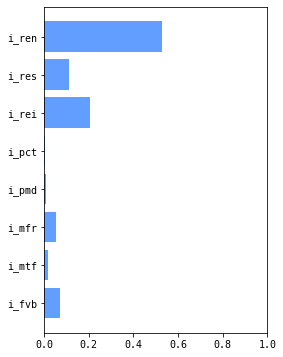

In [24]:
###############################################################################
# Permutation Importance
###############################################################################
(X_trainS, y_trainS) = unison_shuffled_copies(
    X_train, y_train, size=int(5e3)
)
# Permutation scikit ----------------------------------------------------------
timers = {'start': timer()}

perm_importance = permutation_importance(
    rf, X_trainS, y_trainS, 
    scoring=make_scorer(mean_squared_error)
)
sorted_idx = perm_importance.importances_mean.argsort()
pImp = perm_importance.importances_mean/sum(perm_importance.importances_mean)
labZip = zip(perm_importance.importances_mean, indVars[:-1])
labSort = [x for _, x in sorted(labZip)]

timers['ISCI*'] = (timer()-timers['start'])

# Perm figure -----------------------------------------------------------------
clr = selectColor(MOI)
(fig, ax) = plt.subplots(figsize=(4, 6))
plt.barh(indVars[:-1][::-1], pImp[::-1], color=clr, alpha=0.8)
ax.set_xlim(0, 1)
plt.savefig(
    path.join(PT_IMG, fNameOut+'_PERM.png'), 
    dpi=200, bbox_inches='tight', pad_inches=0, transparent=True
)

## MoNeT_DA/PAN/PGM/PGS_mlrTrainMLKeras.py

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


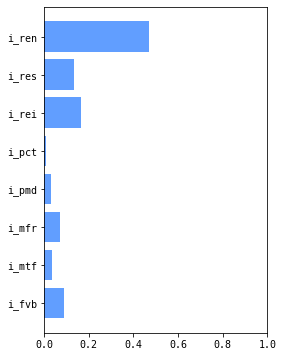

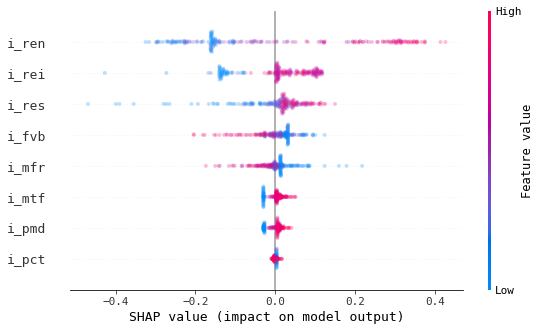

In [25]:
###############################################################################
# SHAP Importance
###############################################################################
(X_trainS, y_trainS) = unison_shuffled_copies(X_train, y_train, size=200)

timers['start'] = timer()

explainer = shap.KernelExplainer(rf.predict, X_trainS)
shap_values = explainer.shap_values(X_trainS, approximate=True)
shapVals = np.abs(shap_values).mean(0)
sImp = shapVals/sum(shapVals)

timers['SHAP*'] = (timer()-timers['start'])

# SHAP figure -----------------------------------------------------------------
clr = selectColor(MOI)
(fig, ax) = plt.subplots(figsize=(4, 6))
plt.barh(indVars[:-1][::-1], sImp[::-1], color=clr, alpha=0.8)
ax.set_xlim(0, 1)
plt.savefig(
    path.join(PT_IMG, fNameOut+'_SHAP.png'), 
    dpi=200, bbox_inches='tight', pad_inches=0, transparent=False
)
(fig, ax) = plt.subplots(figsize=(4, 6))
shap.summary_plot(
    shap_values, X_trainS,
    alpha=0.25, feature_names=indVars,
    show=False
)

In [26]:
timers

{'start': 15.998781493, 'ISCI*': 0.15078295100000005, 'SHAP*': 51.800902717}

In [27]:
###############################################################################
# Dump Importances to Disk
###############################################################################
iVars = [i[0] for i in SA_RANGES]
permSci = pd.DataFrame({
    'names': iVars,
    'mean': perm_importance['importances_mean'], 
    'std': perm_importance['importances_std']
})
shapImp = pd.DataFrame({'names': iVars, 'mean': shapVals})
permSci.to_csv(path.join(PT_OUT, fNameOut+'_PMI-SCI.csv'), index=False)
shapImp.to_csv(path.join(PT_OUT, fNameOut+'_SHP-SHP.csv'), index=False)

## MoNeT_DA/PAN/PGS/PGS_saPlotter.py

In [29]:
###############################################################################
# Reading SA Exported files
###############################################################################
SA_NAMES = ['Delta', 'PAWN', 'HDMR', 'FAST']
name = SA_NAMES[-1]
resultsSA = {}
for name in SA_NAMES:
    fName = path.join(PT_MTR, f'SA-{AOI}_{MOI}-{name}-{QNT}_qnt.csv')
    resultsSA[name] = pd.read_csv(fName)
###############################################################################
# Reading ML Exported files
###############################################################################
if QNT:
    fNameOut = '{}_{}Q_{}T_{}-{}-MLR.png'.format(
        AOI, int(QNT), int(float(THS)*100), MOI, 'mlp'
    )
else:
    fNameOut = '{}_{}T_{}-mlp-MLR.png'.format(AOI, int(float(THS)*100), MOI)
impSci = pd.read_csv(path.join(PT_OUT, fNameOut[:-4]+'_PMI-SCI.csv'))
# impRfi = pd.read_csv(path.join(PT_OUT, fNameOut[:-4]+'_PMI-RFI.csv'))
shpImp = pd.read_csv(path.join(PT_OUT, fNameOut[:-4]+'_SHP-SHP.csv'))
###############################################################################
# Selecting sensitivities
###############################################################################
delta = resultsSA['Delta'][['names', 'delta', 'S1']]
pawn = resultsSA['PAWN'][['names', 'mean', 'median']]
fast = resultsSA['FAST'][['names', 'S1']]
hdmr = resultsSA['HDMR'].iloc[:len(SA_RANGES)][['names', 'S1']]
isci = impSci[['names', 'mean']]
# irfi = impRfi[['Feature', 'Importance']]
shp = shpImp[['names', 'mean']]

In [30]:
###############################################################################
# Reshapping
###############################################################################
iVar = [i[0] for i in DATA_HEAD[:-1]]
validFeat = [sal[0] for sal in SA_RANGES if (len(sal[1])>1)]
# Assemble dataframe ---------------------------------------------------------
df = pd.DataFrame([
        ['Delta', *getSASortedDF(delta, 'S1', validFeat)], 
        ['PAWN',  *getSASortedDF(pawn, 'mean', validFeat)], 
        ['FAST',  *getSASortedDF(fast, 'S1', validFeat)], 
        ['HDMR',  *getSASortedDF(hdmr, 'S1', validFeat)], 
        ['ISCI*',  *getSASortedDF(isci, 'mean', validFeat)], 
        # ['IRFI',  *aux.getSASortedDF(irfi, 'Importance', validFeat)], 
        ['SHAP*',  *getSASortedDF(shp, 'mean', validFeat)], 
    ],
    columns=['name']+validFeat
)
dfT = df.transpose()
new_header = dfT.iloc[0]
dfT = dfT[1:]
dfT.columns = new_header
dfT = dfT.reset_index()
# dfT.sort_values('Delta', ascending=True, inplace=True)

In [32]:
df

,name,ren,rer,rei,pct,pmd,mfr,mtf,fvb
0,Delta,0.703311,0.108150,0.154075,0.000926,0.003242,0.005920,0.005551,0.018826
1,PAWN,0.417827,0.110510,0.152142,0.011539,0.024969,0.071891,0.034725,0.176398
2,FAST,0.707157,0.108245,0.153859,-0.000024,0.002616,0.005327,0.004724,0.018097
3,HDMR,0.611346,0.124110,0.186872,0.001031,0.003881,0.016639,0.006591,0.049529
4,ISCI*,0.526717,0.110252,0.205462,0.004992,0.009002,0.053478,0.019033,0.071064
5,SHAP*,0.468117,0.131915,0.166431,0.007635,0.032679,0.070756,0.033152,0.089316


In [31]:
means = df.mean().to_dict()
means

{'ren': 0.5724124392484967,
 'rer': 0.11553047003337576,
 'rei': 0.1698066933086103,
 'pct': 0.0043495385467699444,
 'pmd': 0.012731366178828514,
 'mfr': 0.03733513478108905,
 'mtf': 0.017296043825358876,
 'fvb': 0.07053831407747078}

In [33]:
df_mean = df.copy()

for col_name in df_mean:
    if col_name != 'name':
        df_mean[col_name] = df_mean[col_name] - means[col_name]

,name,ren,rer,rei,pct,pmd,mfr,mtf,fvb
0,Delta,0.703311,0.108150,0.154075,0.000926,0.003242,0.005920,0.005551,0.018826
1,PAWN,0.417827,0.110510,0.152142,0.011539,0.024969,0.071891,0.034725,0.176398
2,FAST,0.707157,0.108245,0.153859,-0.000024,0.002616,0.005327,0.004724,0.018097
3,HDMR,0.611346,0.124110,0.186872,0.001031,0.003881,0.016639,0.006591,0.049529
4,ISCI*,0.526717,0.110252,0.205462,0.004992,0.009002,0.053478,0.019033,0.071064
5,SHAP*,0.468117,0.131915,0.166431,0.007635,0.032679,0.070756,0.033152,0.089316


In [35]:
df_meanT = df_mean.transpose()
new_mean_header = df_meanT.iloc[0]
df_meanT = df_meanT[1:]
df_meanT.columns = new_mean_header
df_meanT = df_meanT.reset_index()

### Plot on the poster

Text(0.5, 0, 'Importance')

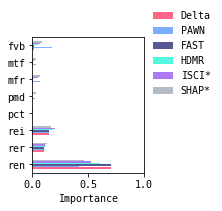

In [36]:
###############################################################################
# SA
###############################################################################
clr = [
    '#FF1A4BAA', '#3a86ffAA', '#03045eAA', '#00f5d4AA', 
    '#8338ecAA','#8d99aeAA', '#cdb4dbAA'
]
dfSA = dfT.drop(['ISCI*', 'SHAP*'], axis=1)
(fig, ax) = plt.subplots(figsize=(2, 2.5))
dfT.plot.barh(
    x='index', stacked=False, xlim=(0, 1), ax=ax,
    ylabel='', xlabel='',
    title='', logx=False, color=clr
)
plt.legend(
    loc='lower left', bbox_to_anchor=(1, 0.5),
    frameon=False
)
ax.set_xlabel("Importance")

## Plot for the difference between specific method and the mean

Text(0.5, 0, 'Importance')

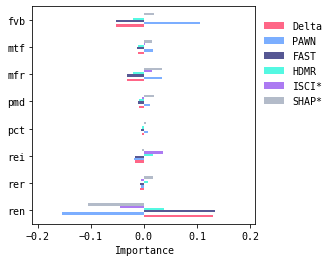

In [38]:
###############################################################################
# The difference between specific method and the mean
###############################################################################
clr = [
    '#FF1A4BAA', '#3a86ffAA', '#03045eAA', '#00f5d4AA', 
    '#8338ecAA','#8d99aeAA', '#cdb4dbAA'
]

(fig, ax) = plt.subplots(figsize=(4, 4))
df_meanT.plot.barh(
    x='index', stacked=False, xlim=(-0.21, 0.21), ax=ax,
    ylabel='', xlabel='',
    title='', logx=False, color=clr
)
plt.legend(
    loc='lower left', bbox_to_anchor=(1, 0.5),
    frameon=False
)
ax.set_xlabel("Importance")

Attempt to set non-positive xlim on a log-scaled axis will be ignored.


Text(0.5, 0, 'Log-Importance')

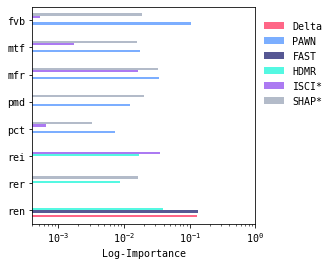

In [39]:
###############################################################################
# log version
###############################################################################
(fig, ax) = plt.subplots(figsize=(4, 4))
df_meanT.plot.barh(
    x='index', stacked=False, xlim=(-1, 1), ax=ax,
    ylabel='', xlabel='',
    title='', logx=True, color=clr
)
plt.legend(
    loc='lower left', bbox_to_anchor=(1, 0.5),
    frameon=False
)
ax.set_xlabel("Log-Importance")